# Crossmatch habitable zone targets with the CKS sample, Gaia DR2 and my own rotation period catalogue.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from astropy.io import fits
from astropy.table import Table
# import chronology as ch

/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/mist/grid.py:193: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = super(MISTModelGrid, self).df_all(phot)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['[Fe/H]']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Load Stephen Kane's list of targets, the CKS catalogue, the McQuillan catalogue, my own rotation period catalogue and Gaia DR2.

In [2]:
# Kane catalogue:
kane = pd.read_csv("../data/kane_targets.csv")

# CKS catalogue:
cks = pd.read_csv("../data/cks_physical_merged.csv")

# McQuillan catalogue:
mc = pd.read_csv("../data/Table_1_Periodic.txt")

# Tim and my catalogue:
tdmra = pd.read_csv("../data/koi_periods_0712.csv")

# Gaia DR2
dat = Table.read('../data/kepler_dr2_4arcsec_updated.fits', format='fits')
dr2 = dat.to_pandas()

/Users/ruthangus/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
cks.head()

What's the overlap between Stephen Kane's catalogue and the CKS sample?

In [3]:
# Format the CKS catalogue and Kane catalogue column headers.
koi_ids = []
for i in cks.id_koicand:
    koi_ids.append("Kepler-{}".format(int(float(i[1:]))))
cks["koi_id"] = koi_ids

KOIs = np.zeros(np.shape(kane)[0], dtype=int)
for j, i in enumerate(kane.koi_id):
    if i[:7] == "Kepler-":
        KOIs[j] = int((float(i[7:])))

kane["KOI"] = KOIs
print(kane.keys(), "\n")
print(cks.keys())
kane_cks = pd.merge(kane, cks, on="koi_id", how="inner", suffixes=["_KIC", "_CKS"])
print(np.shape(kane), np.shape(cks), np.shape(kane_cks))

Index(['koi_id', 'planet_designation', 'p_orb_days', 'a_AU', 'r_pl_earth',
       'teff', 'r_star_rsol', 'insolation_flux_F_E', 'KOI'],
      dtype='object') 

Index(['id_starname', 'id_kic', 'id_koicand', 'id_kepler_name',
       'koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0', 'koi_time0_err1',
       ...
       'iso_sma', 'iso_sma_err1', 'iso_sma_err2', 'iso_insol',
       'iso_insol_err1', 'iso_insol_err2', 'iso_teq', 'iso_teq_err1',
       'iso_teq_err2', 'koi_id'],
      dtype='object', length=121)
(1162, 9) (2025, 121) (617, 129)


617 stars have CKS spectra. ,How many of these stars have rotation periods measured by Amy McQuillan?

In [4]:
kane_cks_mc = pd.merge(kane_cks, mc, left_on="id_kic", right_on="kepid", how="inner", suffixes=["", "_mc"])
np.shape(kane_cks_mc)

(0, 140)

None... How about in Tim and my catalogue?

In [5]:
print(tdmra.keys())

Index(['Unnamed: 0', 'KOI', 'feh', 'feh_errm', 'feh_errp', 'logg', 'logg_errm',
       'logg_errp', 'period', 'period_errm', 'period_errp', 'teff',
       'teff_errm', 'teff_errp'],
      dtype='object')


In [6]:
kane_cks_tdmra = pd.merge(kane_cks, tdmra, on="KOI", how="inner", suffixes=["", "_tdmra"])
np.shape(kane_cks_tdmra)

(552, 142)

How many of these have Gaia DR2 distances?

In [7]:
# Make cuts on parallax signal-to-noise
m = 10 < dr2.parallax_over_error.values  # Signal to noise greater than 10
gdr2 = dr2.iloc[m]

gdr2.kepid.values[0]
int_kepid = []
for i in gdr2.kepid.values:
    int_kepid.append(int(i))
gdr2["int_kepid"] = np.array(int_kepid, dtype=int)

kane_cks_tdmra_dr2 = pd.merge(kane_cks_tdmra, gdr2, left_on="id_kic", right_on="int_kepid", how="inner")
print(np.shape(kane_cks_tdmra_dr2))

kane_cks_tdmra_dr2.to_csv("kane_cks_tdmra_dr2.csv")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(546, 244)



 19.493700177100767

 16.77909257623627


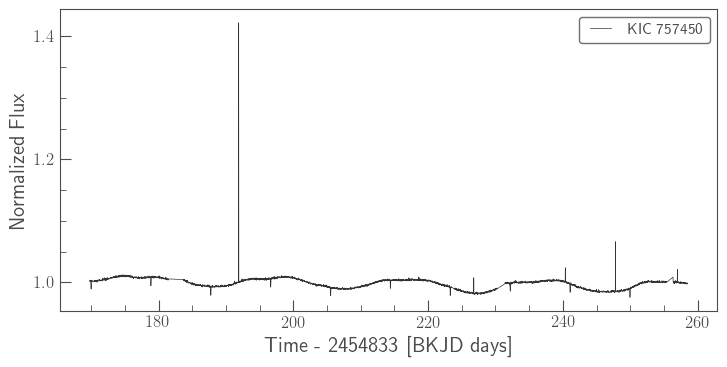

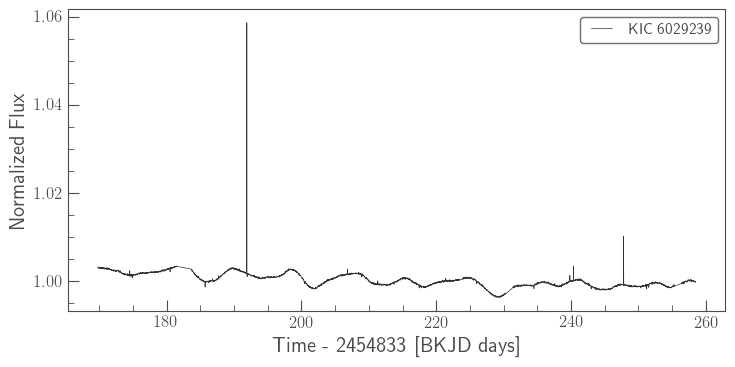

In [26]:
from lightkurve import search_targetpixelfile

for i in range(len(range(2))):#kane_cks_tdmra_dr2)):
    kepid = kane_cks_tdmra_dr2.id_kic.values[i]
    period = kane_cks_tdmra_dr2.period.values[i]
    
    print("\n {}".format(period))

    pixelfile = search_targetpixelfile(kepid, quarter=2).download(quality_bitmask='hardest');

    lc = pixelfile.to_lightcurve(aperture_mask='all');
    lc.plot()

In [23]:
print(kane_cks_tdmra_dr2.koi_period.values[0])
print(kane_cks_tdmra_dr2.koi_duration.values[0])
print(kane_cks_tdmra_dr2.period.values[0])

8.88492268
2.07864
19.493700177100767


So there are 546 stars with spectroscopic properties, distances AND rotation periods. The next thing to do is to combine all this information using isochrones and a gyrochronology model.

In [14]:
df = pd.read_csv("kane_cks_tdmra_dr2.csv")
for k in df.keys():
    print(k)

Unnamed: 0
koi_id
planet_designation
p_orb_days
a_AU
r_pl_earth
teff_x
r_star_rsol
insolation_flux_F_E
KOI
id_starname
id_kic
id_koicand
id_kepler_name
koi_disposition
koi_period
koi_period_err1
koi_period_err2
koi_time0
koi_time0_err1
koi_time0_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_ingress
koi_ingress_err1
koi_ingress_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_ror
koi_ror_err1
koi_ror_err2
koi_srho
koi_srho_err1
koi_srho_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_sma
koi_sma_err1
koi_sma_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_dor
koi_dor_err1
koi_dor_err2
koi_max_mult_ev
koi_model_snr
koi_count
koi_num_transits
koi_steff
koi_steff_err1
koi_steff_err2
koi_slogg
koi_slogg_err1
koi_slogg_err2
koi_smet
koi_smet_err1
koi_smet_err2
koi_srad
koi_srad_err1
koi_srad_err2
koi_smass
koi_smass_err1
koi_smass_err2
koi_sage
koi_sage_err1
koi_sage_err2
koi_sparprov
kic_kepmag
kic_jmag


In [15]:
savedir = "planet_results"

prot, prot_err = df.period, df.period_errm

N = len(df)
for i, id in enumerate(df.id_kic.values):
    print(i, "of", N)
    print("kepid = ", str(id).zfill(9))
    
    iso_params = {"G": (df.phot_g_mean_mag[i], df.phot_g_mean_mag[i]*.05),  # 5% uncertainties on photometry.
                  "bp": (df.phot_bp_mean_mag[i], df.phot_bp_mean_mag[i]*.05),
                  "rp": (df.phot_rp_mean_mag[i], df.phot_rp_mean_mag[i]*.05),
                  "J": (df.kic_jmag[i], df.kic_jmag[i]*.05),
                  "H": (df.kic_hmag[i], df.kic_hmag[i]*.05),
                  "K": (df.kic_kmag[i], df.kic_kmag[i]*.05),
                  "teff": (df.iso_steff[i], df.iso_steff_err2[i]),
                  "logg": (df.iso_slogg[i], df.iso_slogg_err2[i]),
                  "feh": (df.iso_smet[i], df.iso_smet_err2[i]),
                  "parallax": (df.parallax[i], df.parallax_error[i])} 
    
    st = ch.star(iso_params, prot[i], prot_err[i], savedir=savedir, suffix=str(id).zfill(9))
    sampler = st.fit()

    st.make_plots()

0 of 546
kepid =  000757450


  0%|          | 74/100000 [00:01<26:28, 62.90it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
100%|██████████| 100000/100000 [1:08:11<00:00, 24.44it/s] 


nsteps =  100000 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...
1 of 546
kepid =  006029239


  0%|          | 74/100000 [00:01<24:37, 67.63it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 62%|██████▏   | 62000/100000 [27:50<17:03, 37.12it/s]    


nsteps =  62000 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...
2 of 546
kepid =  006029239


  0%|          | 68/100000 [00:00<23:06, 72.05it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 62%|██████▏   | 62000/100000 [25:20<15:32, 40.77it/s]  


nsteps =  62000 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...
3 of 546
kepid =  008041216


  0%|          | 69/100000 [00:01<24:20, 68.44it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 22%|██▏       | 22100/100000 [06:23<22:30, 57.70it/s]  


nsteps =  22100 burnin =  10000
Plotting age posterior
Plotting production chains...
Making corner plot...
4 of 546
kepid =  012105051


  0%|          | 69/100000 [00:00<23:06, 72.07it/s]/Users/ruthangus/anaconda/lib/python3.5/site-packages/isochrones-1.2.2.dev0-py3.5.egg/isochrones/starmodel.py:523: RuntimeWarning: divide by zero encountered in log
  mass_lnprior = np.log(self.prior('mass', masses[0]))
 78%|███████▊  | 78200/100000 [38:17<10:40, 34.04it/s]  


KeyboardInterrupt: 

In [1]:
plt.hist(prot_err/prot);

NameError: name 'plt' is not defined